In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
mnist_train = torchvision.datasets.MNIST(".", train=True, download=True, transform=mnist_transform)
mnist_test = torchvision.datasets.MNIST(".", train=False, download=True, transform=mnist_transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.94MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
class LargeMNIST(nn.Module):
    def __init__(self, dropout_prob: int = 0.1):
        super().__init__()
        
        self.layers = nn.ModuleList ([
            nn.Flatten(),
            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(1200, 10)
        ])

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

In [5]:
large_model = LargeMNIST()

In [6]:
from torchinfo import summary

In [7]:
summary(large_model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LargeMNIST                               [1, 10]                   --
├─ModuleList: 1-1                        --                        --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 1200]                 942,000
│    └─ReLU: 2-3                         [1, 1200]                 --
│    └─Dropout: 2-4                      [1, 1200]                 --
│    └─Linear: 2-5                       [1, 1200]                 1,441,200
│    └─ReLU: 2-6                         [1, 1200]                 --
│    └─Dropout: 2-7                      [1, 1200]                 --
│    └─Linear: 2-8                       [1, 10]                   12,010
Total params: 2,395,210
Trainable params: 2,395,210
Non-trainable params: 0
Total mult-adds (M): 2.40
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 9.58
Estimated Total Size (MB

In [8]:
from torch.utils.data import random_split

In [9]:
# Define split ratios
train_size = int(0.8 * len(mnist_train))
val_size = int(0.2 * len(mnist_train))

# Split dataset
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

In [10]:
from torch.utils.data import DataLoader

In [11]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

pred_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
import math

In [14]:
learning_rate = 1e-3
weight_decay = 1e-4

# less epoch as can easily overfit
num_epoch = 10

lossi_train = []
lossi_val = []
metric_val = []

total_samples = len(train_loader)
n_iter = math.ceil(total_samples / batch_size)

optimizer = torch.optim.AdamW(large_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
ce_loss = nn.CrossEntropyLoss()
output_grads = []

large_model = large_model.to(device)

for epoch in range(num_epoch):
    large_model.train()
    
    train_loss = 0    
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # print(f"inputs: {inputs}")
        # print(f"labels: {labels}")
        inputs = inputs.to(device)
        labels = labels.to(device)

        # print(f"inputs device: {inputs.device}, labels device: {labels.device}, model device: {[param.device for param in model.parameters()]}")
        
        pred = large_model(inputs)
        # print(f"pred: {pred}")

        loss = ce_loss(pred, labels)
        
        loss.backward()
        optimizer.step()
        loss = loss.log10()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    lossi_train.append(train_loss)

    large_model.eval()
    
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():   
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            pred = large_model(inputs)
            predictions = nn.functional.softmax(pred, dim=-1)
            
            y_pred_labels = torch.argmax(predictions, dim=1)        
            correct += (y_pred_labels == labels).sum().item()
            total += labels.size(0)
            
            loss = ce_loss(pred, labels)
            loss = loss.log10()
            val_loss += loss.item()
        
        val_accuracy = correct / total
        metric_val.append(val_accuracy)
        val_loss /= len(val_loader)
        lossi_val.append(val_loss)

    if ((epoch+1)%1==0):
        print(f"Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Metric: {val_accuracy:.4f}")

Epoch 1/10, Train Loss: -0.8417, Val Loss: -1.1522, Val Metric: 0.9646
Epoch 2/10, Train Loss: -1.2300, Val Loss: -1.1677, Val Metric: 0.9663
Epoch 3/10, Train Loss: -1.4659, Val Loss: -1.2587, Val Metric: 0.9663
Epoch 4/10, Train Loss: -1.6565, Val Loss: -1.3916, Val Metric: 0.9724
Epoch 5/10, Train Loss: -1.8257, Val Loss: -1.5411, Val Metric: 0.9772
Epoch 6/10, Train Loss: -2.0261, Val Loss: -1.6450, Val Metric: 0.9780
Epoch 7/10, Train Loss: -2.1690, Val Loss: -1.7625, Val Metric: 0.9777
Epoch 8/10, Train Loss: -2.2466, Val Loss: -1.7931, Val Metric: 0.9774
Epoch 9/10, Train Loss: -2.4019, Val Loss: -2.0202, Val Metric: 0.9825
Epoch 10/10, Train Loss: -2.6109, Val Loss: -2.0576, Val Metric: 0.9818


In [15]:
import matplotlib.pyplot as plt

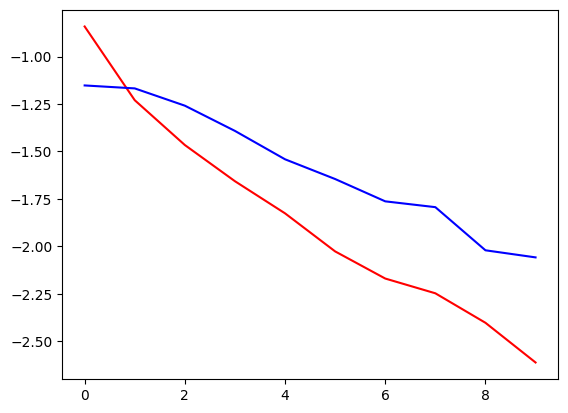

In [16]:
plt.plot(lossi_train, c="red")
plt.plot(lossi_val, c="blue")

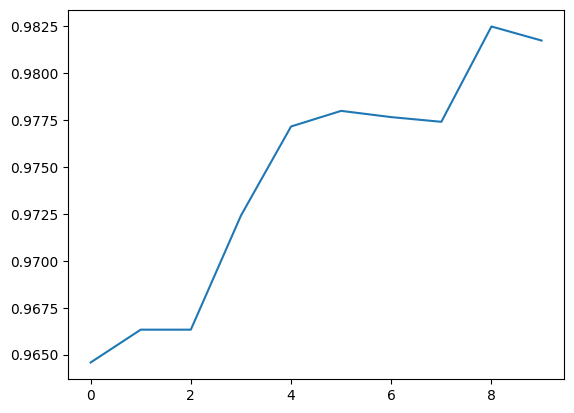

In [17]:
plt.plot(metric_val)

In [18]:
class SmallMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.ModuleList ([
            nn.Flatten(),
            
            nn.Linear(28*28, 300),
            nn.ReLU(),

            nn.Linear(300, 300),
            nn.ReLU(),

            nn.Linear(300, 10)
        ])

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

In [19]:
small_model = SmallMNIST()

In [20]:
summary(small_model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SmallMNIST                               [1, 10]                   --
├─ModuleList: 1-1                        --                        --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 300]                  235,500
│    └─ReLU: 2-3                         [1, 300]                  --
│    └─Linear: 2-4                       [1, 300]                  90,300
│    └─ReLU: 2-5                         [1, 300]                  --
│    └─Linear: 2-6                       [1, 10]                   3,010
Total params: 328,810
Trainable params: 328,810
Non-trainable params: 0
Total mult-adds (M): 0.33
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.32
Estimated Total Size (MB): 1.32

In [21]:
learning_rate = 1e-3
weight_decay = 1e-4

soft_target_weight = 100
label_loss_weight = 0.5
temperature = 2.5


# less epoch as can easily overfit
num_epoch = 10

lossi_train = []
lossi_val = []
metric_val = []

total_samples = len(train_loader)
n_iter = math.ceil(total_samples / batch_size)

optimizer = torch.optim.AdamW(small_model.parameters(), lr=learning_rate)
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(log_target=True)

output_grads = []

large_model = large_model.to(device)
large_model.eval()

small_model = small_model.to(device)

for epoch in range(num_epoch):
    small_model.train()
    
    train_loss = 0    
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # print(f"inputs: {inputs}")
        # print(f"labels: {labels}")
        inputs = inputs.to(device)
        labels = labels.to(device)

        # print(f"inputs device: {inputs.device}, labels device: {labels.device}, model device: {[param.device for param in model.parameters()]}")

        with torch.no_grad():
            logits_large_model = large_model(inputs)
        logits_small_model = small_model(inputs)
        
        # print(f"pred: {pred}")
        large_soft_prob = nn.functional.log_softmax(logits_large_model / temperature, dim=-1)
        small_soft_prob = nn.functional.log_softmax(logits_small_model / temperature, dim=-1)
        
        loss = (label_loss_weight * ce_loss(logits_small_model, labels)) + (soft_target_weight * kl_loss(small_soft_prob, large_soft_prob))
        
        loss.backward()
        optimizer.step()
        loss = loss.log10()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    lossi_train.append(train_loss)

    small_model.eval()
    
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():   
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            pred = small_model(inputs)
            predictions = nn.functional.softmax(pred, dim=-1)  # Apply sigmoid for binary classification
            
            y_pred_labels = torch.argmax(predictions, dim=1)        
            correct += (y_pred_labels == labels).sum().item()
            total += labels.size(0)
            
            loss = ce_loss(pred, labels)
            loss = loss.log10()
            val_loss += loss.item()
        
        val_accuracy = correct / total
        metric_val.append(val_accuracy)
        val_loss /= len(val_loader)
        lossi_val.append(val_loss)

    if ((epoch+1)%1==0):
        print(f"Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Metric: {val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1/10, Train Loss: 0.2713, Val Loss: -1.1728, Val Metric: 0.9605
Epoch 2/10, Train Loss: -0.1848, Val Loss: -1.5388, Val Metric: 0.9718
Epoch 3/10, Train Loss: -0.4133, Val Loss: -1.6273, Val Metric: 0.9753
Epoch 4/10, Train Loss: -0.5892, Val Loss: -1.7101, Val Metric: 0.9758
Epoch 5/10, Train Loss: -0.6962, Val Loss: -1.6687, Val Metric: 0.9768
Epoch 6/10, Train Loss: -0.7961, Val Loss: -1.8097, Val Metric: 0.9765
Epoch 7/10, Train Loss: -0.8441, Val Loss: -1.8185, Val Metric: 0.9777
Epoch 8/10, Train Loss: -0.9160, Val Loss: -1.9515, Val Metric: 0.9788
Epoch 9/10, Train Loss: -0.9372, Val Loss: -1.9178, Val Metric: 0.9788
Epoch 10/10, Train Loss: -0.9698, Val Loss: -1.9839, Val Metric: 0.9800


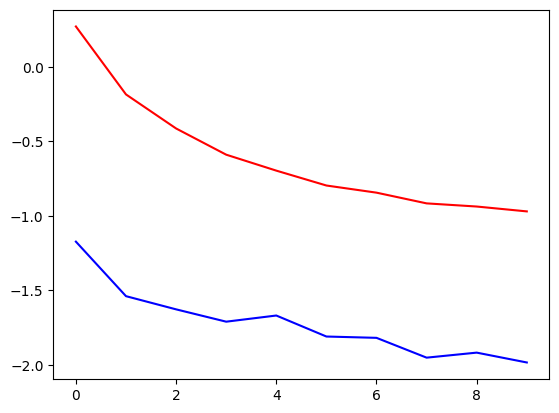

In [22]:
plt.plot(lossi_train, c="red")
plt.plot(lossi_val, c="blue")

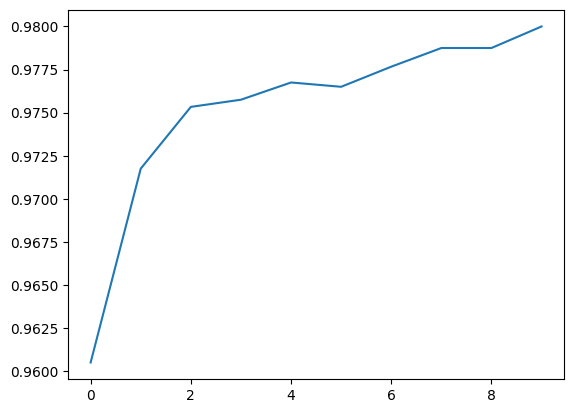

In [23]:
plt.plot(metric_val)